In [6]:
!git clone https://github.com/karoldvl/ESC-50.git

Cloning into 'ESC-50'...
remote: Enumerating objects: 4199, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 4199 (delta 62), reused 34 (delta 34), pack-reused 4130 (from 1)
Receiving objects: 100% (4199/4199), 878.77 MiB | 29.26 MiB/s, done.
Resolving deltas: 100% (292/292), done.
Updating files: 100% (2011/2011), done.


In [5]:
import os
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import resampy
import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [ ]:
# Path to the ESC-50 dataset
csv_path = '/content/ESC-50/meta/esc50.csv'
audio_path = '/content/ESC-50/audio/'

# Load csv file
meta = pd.read_csv(csv_path)
print(f"Dataset Shape: {meta.shape}")
print("\nColumns in the dataset:")
print(meta.columns)
print("\n",meta.head(10))

Dataset Shape: (2000, 7)

Columns in the dataset:
Index(['filename', 'fold', 'target', 'category', 'esc10', 'src_file', 'take'], dtype='object')

             filename  fold  target         category  esc10  src_file take
0   1-100032-A-0.wav     1       0              dog   True    100032    A
1  1-100038-A-14.wav     1      14   chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36   vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36   vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19     thunderstorm  False    101296    A
5  1-101296-B-19.wav     1      19     thunderstorm  False    101296    B
6  1-101336-A-30.wav     1      30  door_wood_knock  False    101336    A
7  1-101404-A-34.wav     1      34      can_opening  False    101404    A
8   1-103298-A-9.wav     1       9             crow  False    103298    A
9  1-103995-A-30.wav     1      30  door_wood_knock  False    103995    A


Sample Rate of the Audio:  22050


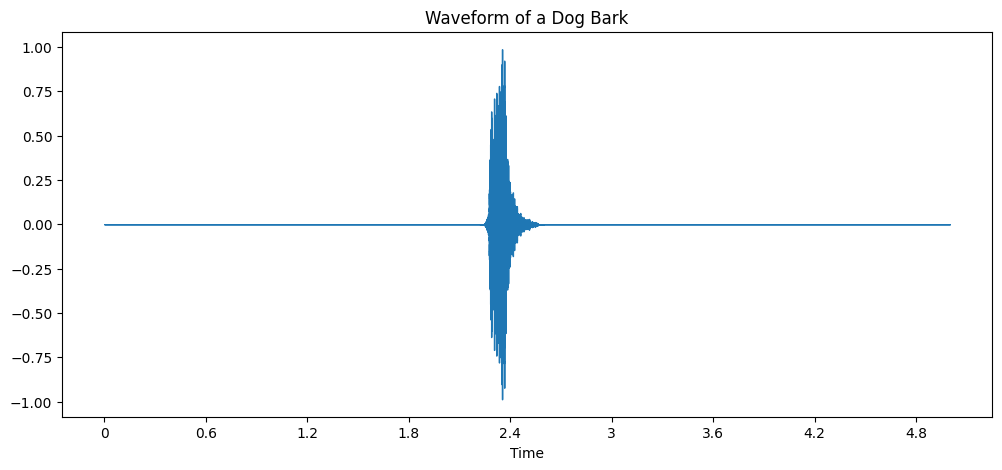

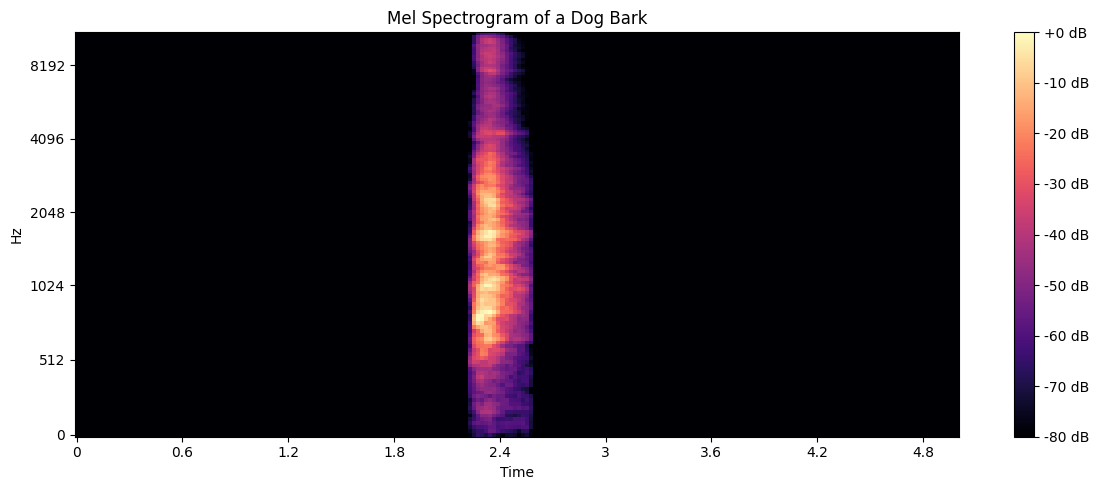

In [ ]:
# Waveform
data, sample_rate = librosa.load("/content/ESC-50/audio/1-100032-A-0.wav")
plt.figure(figsize=(12, 5))
plt.title('Waveform of a Dog Bark')
librosa.display.waveshow(data, sr=sample_rate)
print('Sample Rate of the Audio: ',sample_rate)

# Mel Spectogram
mel_spec = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=128)
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(12, 5))
librosa.display.specshow(log_mel_spec, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel Spectrogram of a Dog Bark')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

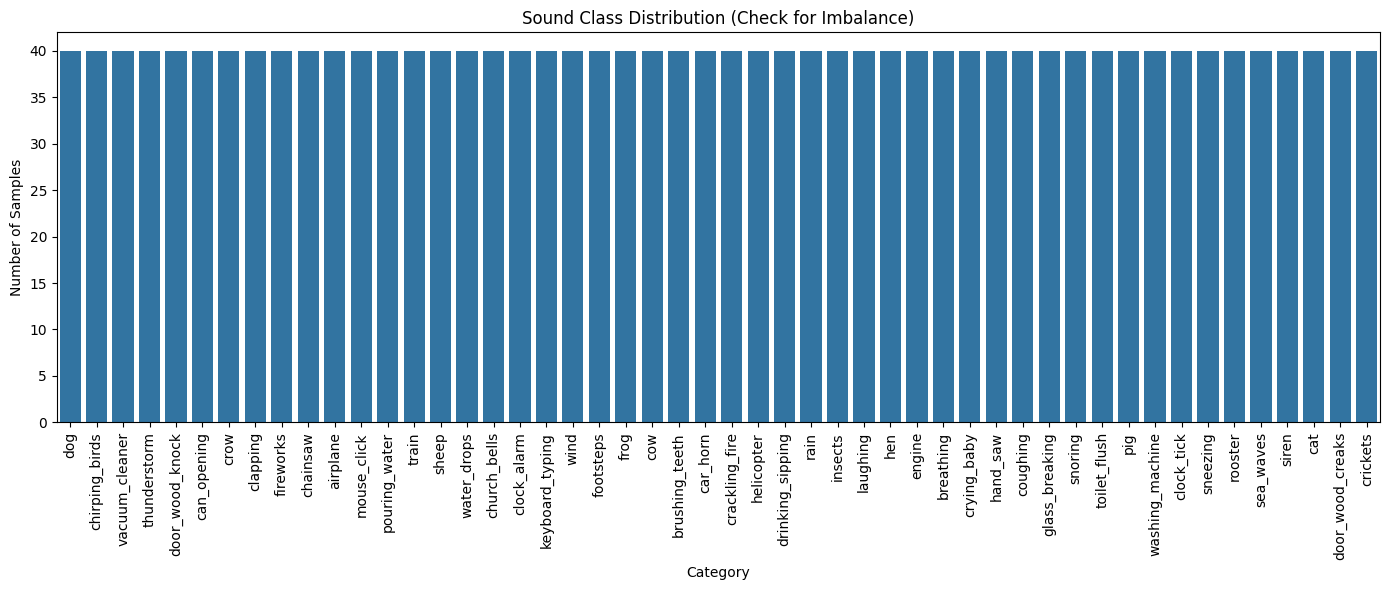

In [ ]:
# Class Imbalance

plt.figure(figsize=(14, 6))
sns.countplot(data=meta, x='category', order=meta['category'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Sound Class Distribution (Check for Imbalance)')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()

In [ ]:
# MFCC Feature Extraction

meta_df = pd.read_csv("/content/ESC-50/meta/esc50.csv")

# STEP 2: Feature Extraction
def extract_features(file_path):
    audio, sr = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    return mfccs_scaled

features, labels = [], []

for index, row in meta_df.iterrows():
    file_path = f"/content/ESC-50/audio/{row['filename']}" # Audio File Path
    try:
        mfccs = extract_features(file_path)
        features.append(mfccs)
        labels.append(row["category"])
    except Exception as e:
        print(f"Error with {file_path}: {e}")

X = np.array(features)
y = np.array(labels)

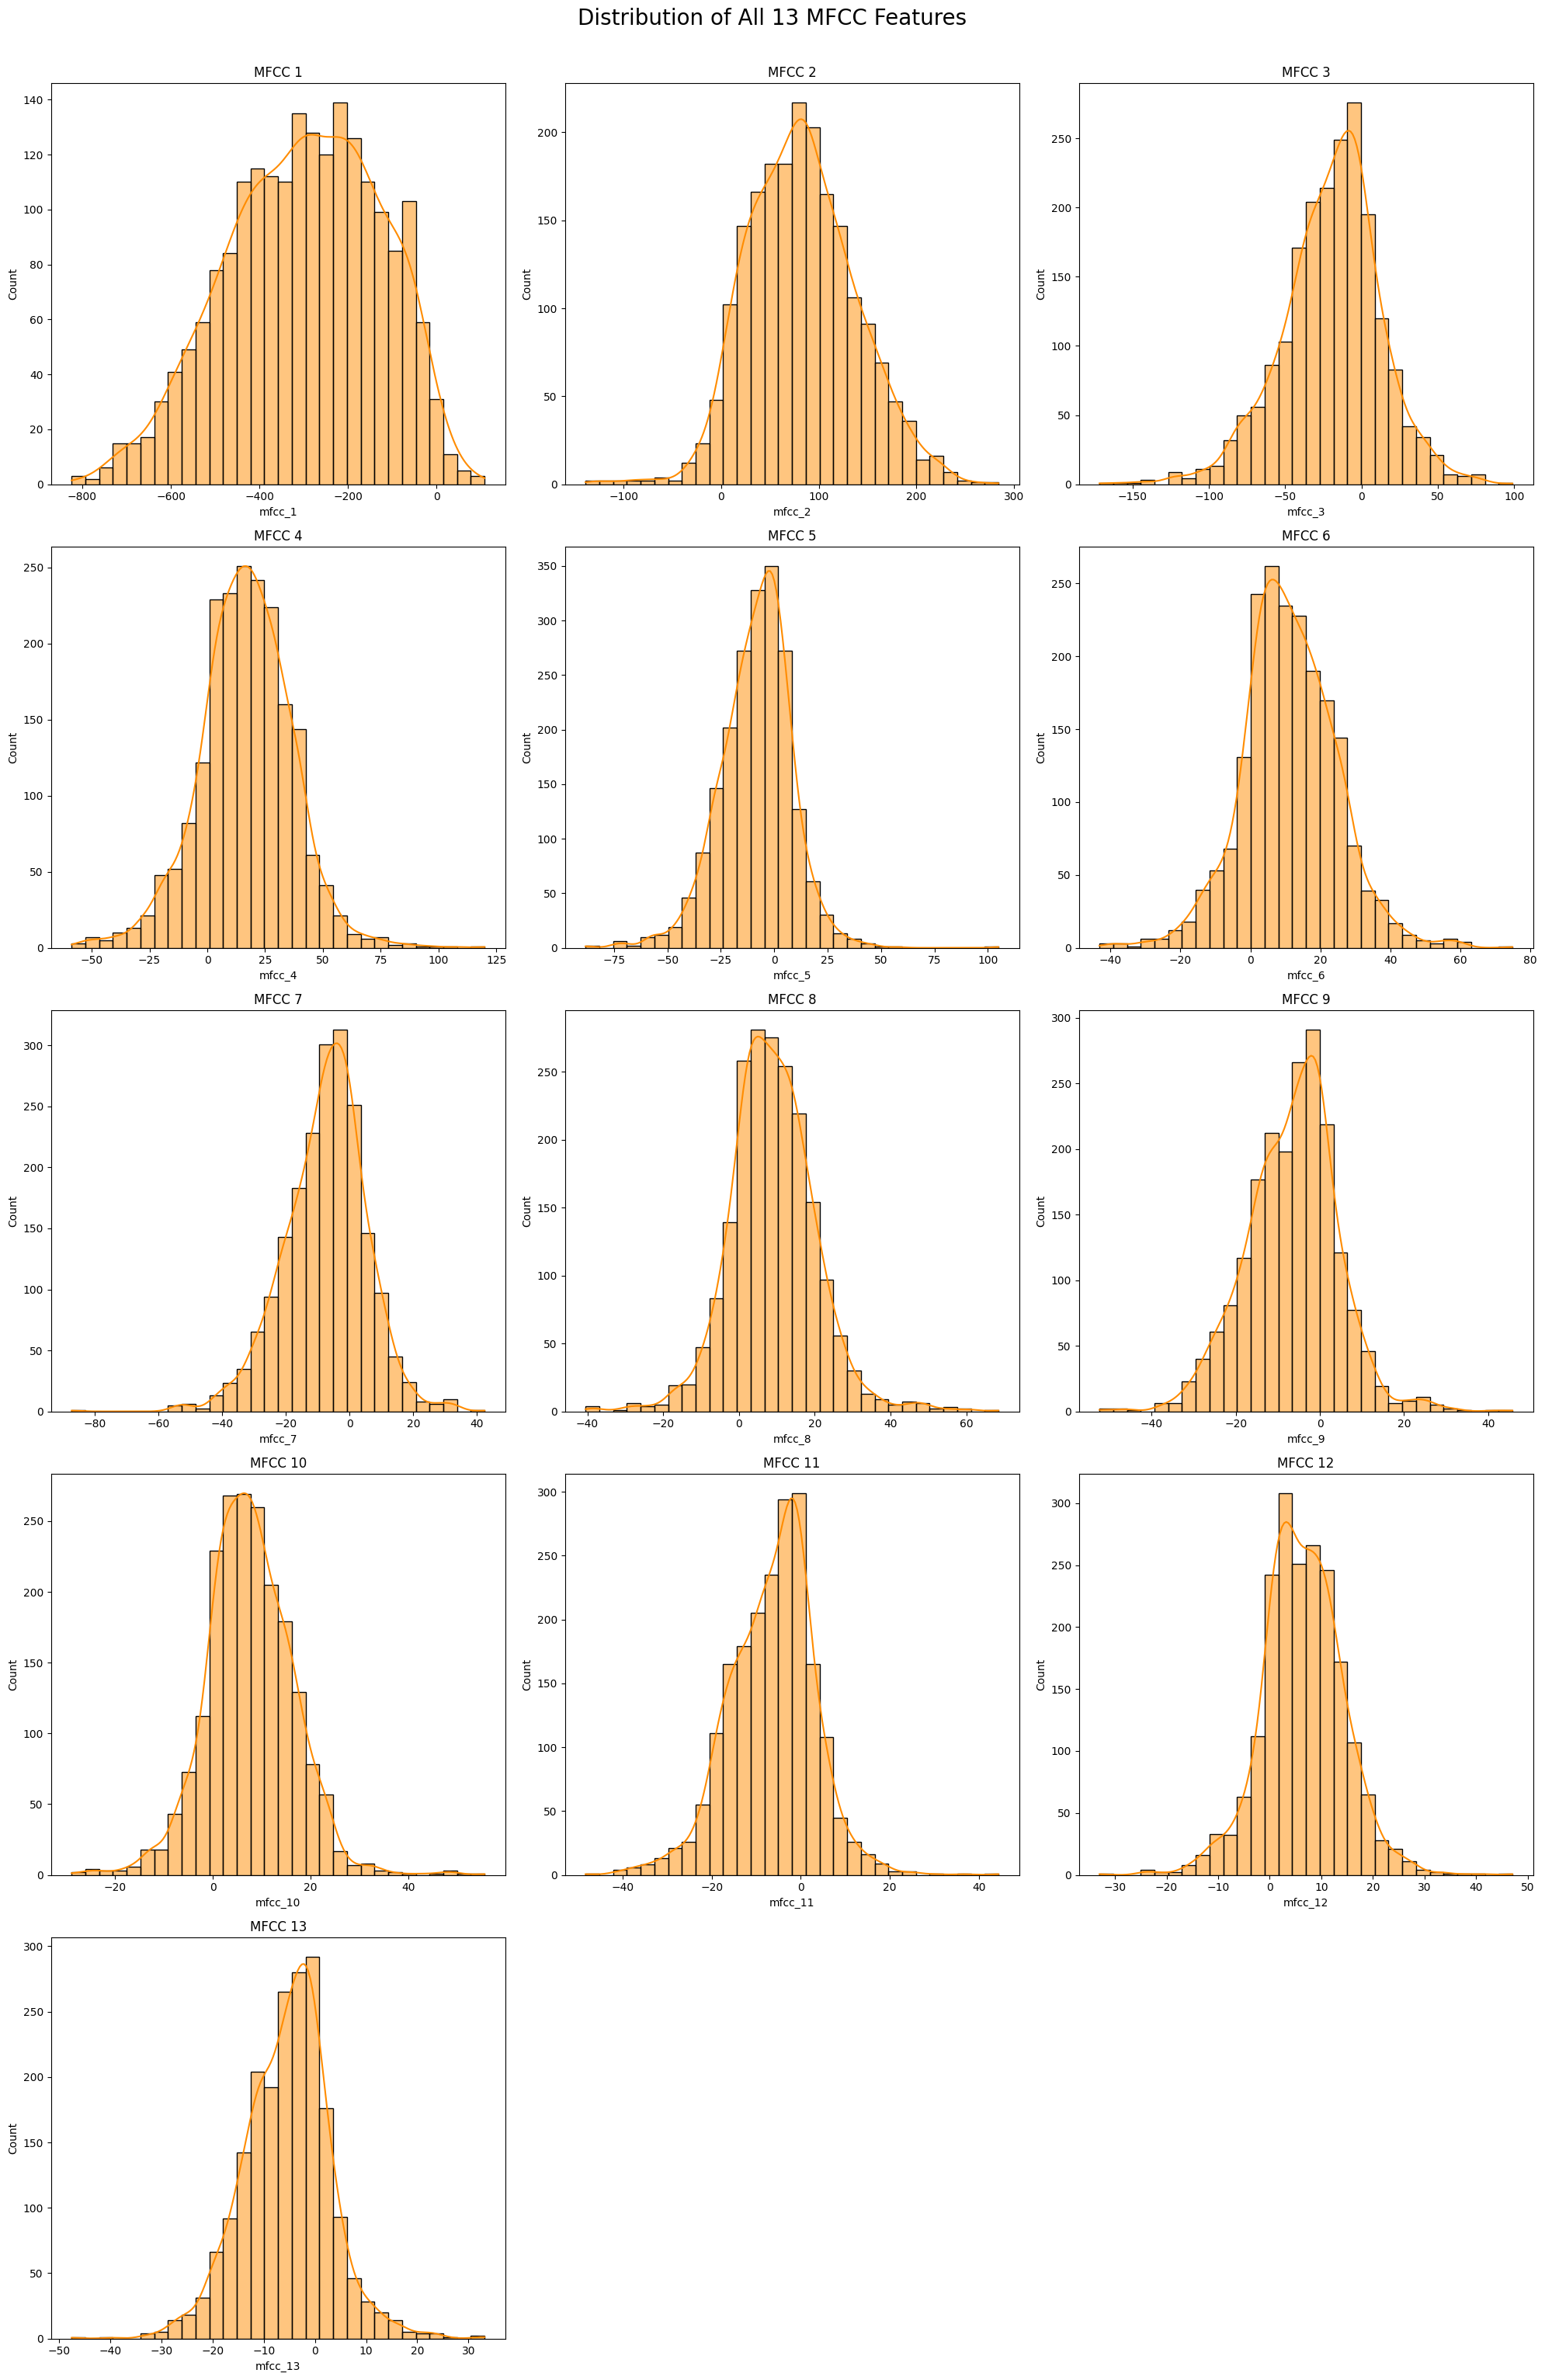

In [ ]:
mfcc_df = pd.DataFrame(X, columns=[f"mfcc_{i+1}" for i in range(X.shape[1])])
plt.figure(figsize=(20, 30))
for i in range(13):
    plt.subplot(5, 3, i + 1)  # 5 rows x 3 columns grid
    sns.histplot(mfcc_df.iloc[:, i], kde=True, bins=30, color='darkorange')
    plt.title(f"MFCC {i+1}")
    plt.tight_layout()

plt.suptitle("Distribution of All 13 MFCC Features", fontsize=20, y=1.02)
plt.show()

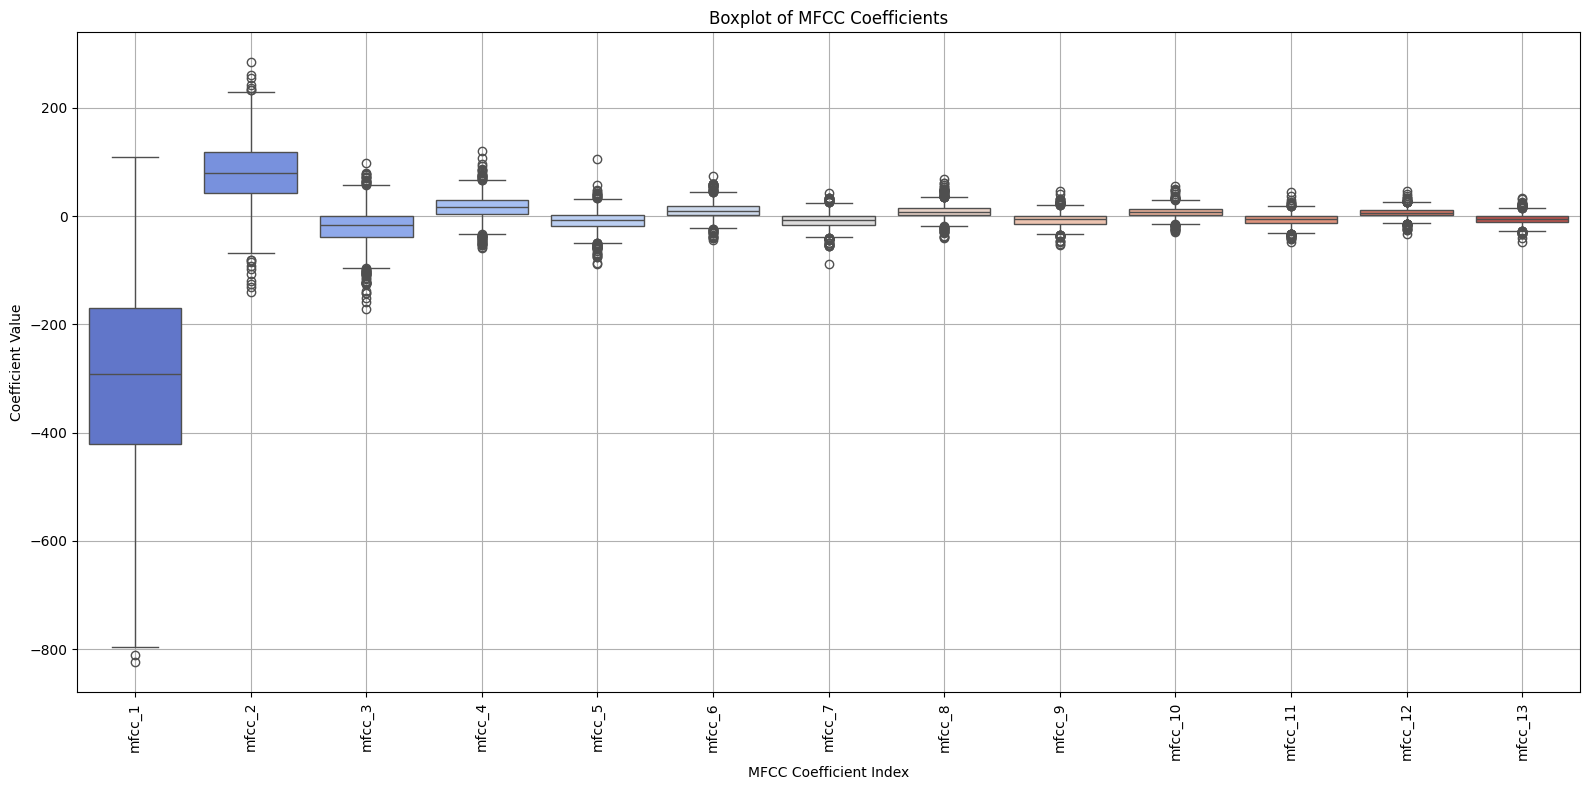

In [ ]:
# Boxplots for feature engineering

plt.figure(figsize=(16, 8))
sns.boxplot(data=mfcc_df, palette='coolwarm')
plt.title("Boxplot of MFCC Coefficients")
plt.xlabel("MFCC Coefficient Index")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

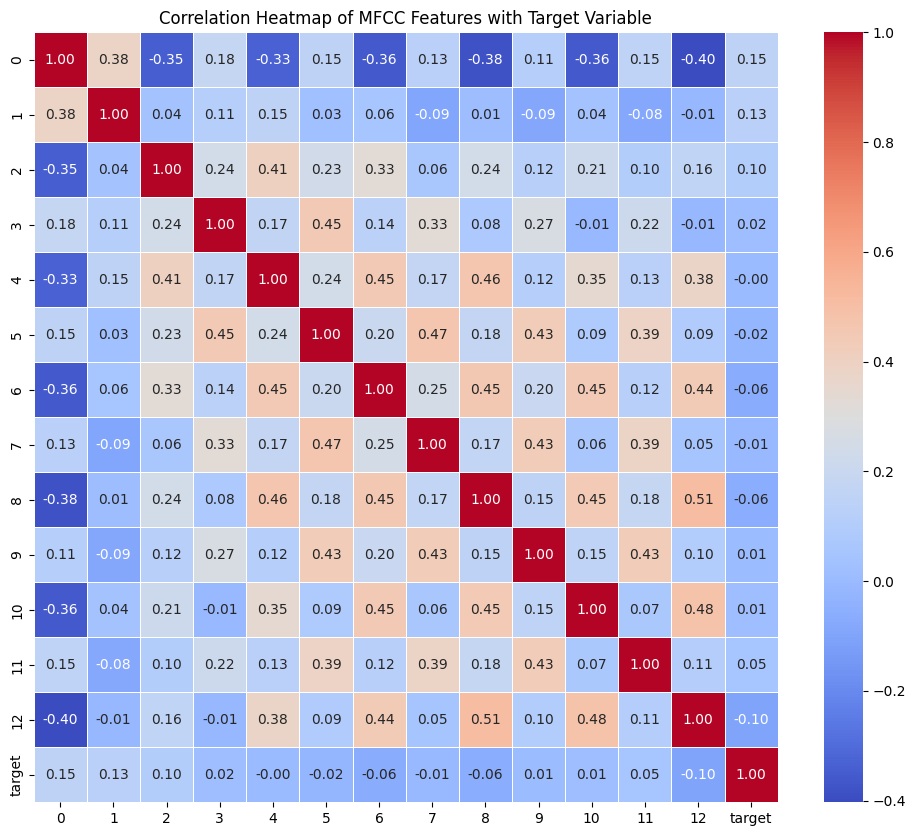

In [ ]:
# Step 1: Label Encoding (convert target labels to numbers)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # y_encoded will be numerical labels

# Step 2: Calculate Correlation
# Combine features and target labels into a single DataFrame for easy correlation computation
df_features = pd.DataFrame(X)  # MFCC features (shape: samples x 40)
df_target = pd.DataFrame(y_encoded, columns=["target"])  # Target labels

# Concatenate features and target variable into a single DataFrame
df = pd.concat([df_features, df_target], axis=1)

# Calculate correlation matrix
corr_matrix = df.corr()

# Step 3: Plot the Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of MFCC Features with Target Variable")
plt.show()

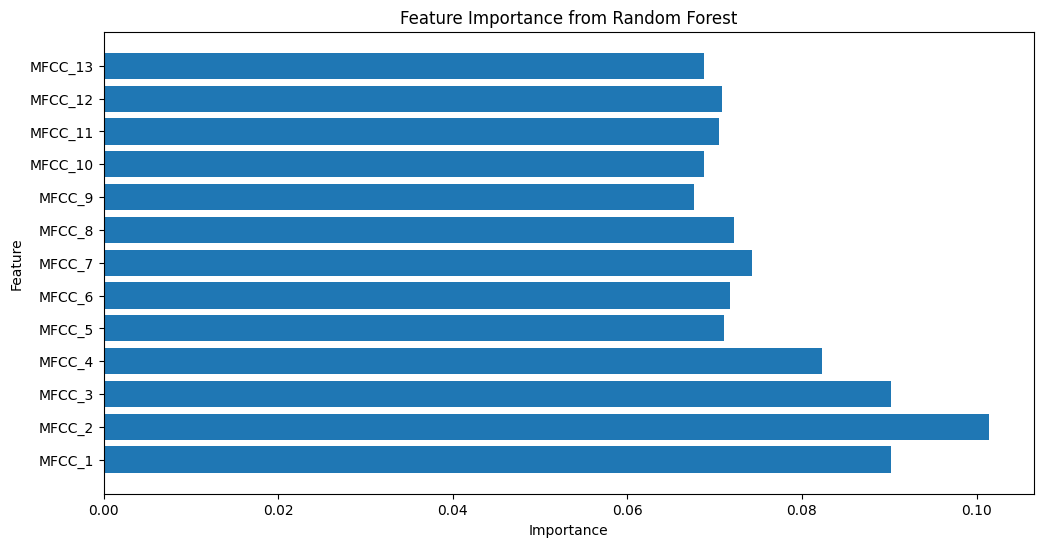

In [ ]:
rf = RandomForestClassifier()
rf.fit(X, y)

# Get feature importance
importances = rf.feature_importances_

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), [f"MFCC_{i+1}" for i in range(len(importances))])
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalize for ML models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

(1600, 13)
(400, 13)
(1600,)
(400,)


In [ ]:
# Baseline Model

dummy = DummyClassifier(strategy="uniform")
dummy.fit(X_train, y_train)
dummy_preds = dummy.predict(X_test)

print("Dummy Classifier Accuracy:", accuracy_score(y_test, dummy_preds))
print(classification_report(y_test, dummy_preds))

Dummy Classifier Accuracy: 0.0225
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         8
           2       0.11      0.14      0.12         7
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00         5
          12       0.09      0.10      0.10        10
          13       0.00      0.00      0.00        13
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         6
          16       0.00      0.00      0.00    

In [ ]:
def objective_logreg(trial):
    C = trial.suggest_loguniform('C', 1e-4, 1e2)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])

    model = LogisticRegression(C=C, solver=solver, max_iter=500)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    return accuracy_score(y_test, y_pred)

study_logreg = optuna.create_study(direction='maximize')
study_logreg.optimize(objective_logreg, n_trials=50)

best_logreg = LogisticRegression(**study_logreg.best_params, max_iter=500)
best_logreg.fit(X_train_scaled, y_train)
y_pred_lr = best_logreg.predict(X_test_scaled)


[I 2025-05-08 14:01:50,179] A new study created in memory with name: no-name-f195e7bb-105c-48bd-a547-10789b78724e
[I 2025-05-08 14:01:50,393] Trial 0 finished with value: 0.31 and parameters: {'C': 57.49755657017327, 'solver': 'liblinear'}. Best is trial 0 with value: 0.31.
[I 2025-05-08 14:01:50,837] Trial 1 finished with value: 0.295 and parameters: {'C': 0.07292845597886131, 'solver': 'saga'}. Best is trial 0 with value: 0.31.
[I 2025-05-08 14:01:51,573] Trial 2 finished with value: 0.3275 and parameters: {'C': 2.416088974613634, 'solver': 'lbfgs'}. Best is trial 2 with value: 0.3275.
[I 2025-05-08 14:01:51,828] Trial 3 finished with value: 0.0 and parameters: {'C': 0.0001878831982207053, 'solver': 'lbfgs'}. Best is trial 2 with value: 0.3275.
[I 2025-05-08 14:01:52,586] Trial 4 finished with value: 0.3225 and parameters: {'C': 4.709008736823493, 'solver': 'lbfgs'}. Best is trial 2 with value: 0.3275.
[I 2025-05-08 14:01:58,579] Trial 5 finished with value: 0.33 and parameters: {'C'

In [ ]:
def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    return accuracy_score(y_test, y_pred)

study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(objective_knn, n_trials=50)

best_knn = KNeighborsClassifier(**study_knn.best_params)
best_knn.fit(X_train_scaled, y_train)
y_pred_knn = best_knn.predict(X_test_scaled)


[I 2025-05-08 14:03:01,498] A new study created in memory with name: no-name-7f1e870e-771b-466e-a000-a829165207af
[I 2025-05-08 14:03:01,545] Trial 0 finished with value: 0.36 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: 0.36.
[I 2025-05-08 14:03:01,590] Trial 1 finished with value: 0.2975 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.36.
[I 2025-05-08 14:03:01,617] Trial 2 finished with value: 0.3675 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 2 with value: 0.3675.
[I 2025-05-08 14:03:01,659] Trial 3 finished with value: 0.345 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 2 with value: 0.3675.
[I 2025-05-08 14:03:01,717] Trial 4 finished with value: 0.2575 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 2 wi

In [ ]:
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        criterion=criterion
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return accuracy_score(y_test, y_pred)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50)

best_rf = RandomForestClassifier(**study_rf.best_params)
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)

[I 2025-05-08 14:03:13,276] A new study created in memory with name: no-name-187612f6-c940-4983-a54c-010f12f2e757
[I 2025-05-08 14:03:16,009] Trial 0 finished with value: 0.4225 and parameters: {'n_estimators': 252, 'max_depth': 46, 'min_samples_split': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.4225.
[I 2025-05-08 14:03:21,772] Trial 1 finished with value: 0.3775 and parameters: {'n_estimators': 242, 'max_depth': 46, 'min_samples_split': 7, 'criterion': 'entropy'}. Best is trial 0 with value: 0.4225.
[I 2025-05-08 14:03:23,550] Trial 2 finished with value: 0.4325 and parameters: {'n_estimators': 145, 'max_depth': 46, 'min_samples_split': 2, 'criterion': 'gini'}. Best is trial 2 with value: 0.4325.
[I 2025-05-08 14:03:26,384] Trial 3 finished with value: 0.4125 and parameters: {'n_estimators': 82, 'max_depth': 23, 'min_samples_split': 6, 'criterion': 'entropy'}. Best is trial 2 with value: 0.4325.
[I 2025-05-08 14:03:28,821] Trial 4 finished with value: 0.3175 and parameter

In [ ]:
def objective_svm(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e2)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    model = SVC(C=C, kernel=kernel, gamma=gamma)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    return accuracy_score(y_test, y_pred)

study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=50)

best_svm = SVC(**study_svm.best_params)
best_svm.fit(X_train_scaled, y_train)
y_pred_svm = best_svm.predict(X_test_scaled)

[I 2025-05-08 14:06:06,944] A new study created in memory with name: no-name-e7d29d12-7d90-4784-8bd9-93c2eaabb7e8
[I 2025-05-08 14:06:07,204] Trial 0 finished with value: 0.4175 and parameters: {'C': 44.75272928247834, 'kernel': 'poly', 'gamma': 'auto'}. Best is trial 0 with value: 0.4175.
[I 2025-05-08 14:06:07,478] Trial 1 finished with value: 0.0 and parameters: {'C': 0.0011124746592747203, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 0 with value: 0.4175.
[I 2025-05-08 14:06:07,918] Trial 2 finished with value: 0.03 and parameters: {'C': 0.0031999730019488487, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.4175.
[I 2025-05-08 14:06:08,427] Trial 3 finished with value: 0.43 and parameters: {'C': 4.4621424739532145, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 3 with value: 0.43.
[I 2025-05-08 14:06:10,289] Trial 4 finished with value: 0.395 and parameters: {'C': 10.341728677988204, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 3 with value: 0.43

In [ ]:
X_train_ann = X_train_scaled
X_test_ann = X_test_scaled
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

def objective_ann(trial):
    model = Sequential()
    model.add(Dense(trial.suggest_int('units1', 64, 512), input_shape=(X_train_ann.shape[1],), activation='relu'))
    model.add(Dropout(trial.suggest_float('dropout1', 0.2, 0.5)))

    model.add(Dense(trial.suggest_int('units2', 32, 256), activation='relu'))
    model.add(Dropout(trial.suggest_float('dropout2', 0.2, 0.5)))

    model.add(Dense(50, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.fit(X_train_ann, y_train_cat,
              validation_data=(X_test_ann, y_test_cat),
              epochs=trial.suggest_int('epochs', 30, 150),
              batch_size=32, verbose=0)

    score = model.evaluate(X_test_ann, y_test_cat, verbose=0)
    return score[1]  # Accuracy

study_ann = optuna.create_study(direction='maximize')
study_ann.optimize(objective_ann, n_trials=50)

# Rebuild best model using best parameters
best_params = study_ann.best_params
ann = Sequential()
ann.add(Dense(best_params['units1'], input_shape=(X_train_ann.shape[1],), activation='relu'))
ann.add(Dropout(best_params['dropout1']))
ann.add(Dense(best_params['units2'], activation='relu'))
ann.add(Dropout(best_params['dropout2']))
ann.add(Dense(50, activation='softmax'))

ann.compile(optimizer=Adam(learning_rate=best_params['lr']),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

ann.fit(X_train_ann, y_train_cat,
        validation_data=(X_test_ann, y_test_cat),
        epochs=best_params['epochs'],
        batch_size=32,
        verbose=0)

y_pred_ann = np.argmax(ann.predict(X_test_ann), axis=1)

[I 2025-05-08 14:06:36,597] A new study created in memory with name: no-name-0a50feed-950d-411c-a3ba-a9c46a247008
[I 2025-05-08 14:07:12,356] Trial 0 finished with value: 0.4074999988079071 and parameters: {'units1': 463, 'dropout1': 0.21668729230723976, 'units2': 44, 'dropout2': 0.4711609677703377, 'lr': 0.000840721356906316, 'epochs': 116}. Best is trial 0 with value: 0.4074999988079071.
[I 2025-05-08 14:07:54,761] Trial 1 finished with value: 0.45500001311302185 and parameters: {'units1': 199, 'dropout1': 0.2377655537426529, 'units2': 175, 'dropout2': 0.24813892601603238, 'lr': 0.007458776858221931, 'epochs': 134}. Best is trial 1 with value: 0.45500001311302185.
[I 2025-05-08 14:08:35,057] Trial 2 finished with value: 0.47749999165534973 and parameters: {'units1': 390, 'dropout1': 0.2603056100782239, 'units2': 244, 'dropout2': 0.3299197568267166, 'lr': 0.001540974090869691, 'epochs': 107}. Best is trial 2 with value: 0.47749999165534973.
[I 2025-05-08 14:08:47,669] Trial 3 finished

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [ ]:
# STEP 6: Collect All Metrics
results = {
    "Logistic Regression": accuracy_score(y_test, y_pred_lr),
    "KNN": accuracy_score(y_test, y_pred_knn),
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "SVM": accuracy_score(y_test, y_pred_svm),
    "ANN": accuracy_score(y_test, y_pred_ann)
}

metrics = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

def evaluate_model(name, y_true, y_pred):
    metrics["Model"].append(name)
    metrics["Accuracy"].append(f"{accuracy_score(y_true, y_pred):.2f}")
    metrics["Precision"].append(f"{precision_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")
    metrics["Recall"].append(f"{precision_score(y_true, y_pred, average='weighted'):.2f}")
    metrics["F1 Score"].append(f"{f1_score(y_true, y_pred, average='weighted'):.2f}")

# Evaluate all
evaluate_model("Logistic Regression", y_test, y_pred_lr)
evaluate_model("KNN", y_test, y_pred_knn)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("SVM", y_test, y_pred_svm)
evaluate_model("ANN", y_test, y_pred_ann)

metrics_df = pd.DataFrame(metrics)
print("\n Metrics: \n")
print(metrics_df)


 Metrics: 

                 Model Accuracy Precision Recall F1 Score
0  Logistic Regression     0.33      0.39   0.39     0.33
1                  KNN     0.44      0.50   0.50     0.44
2        Random Forest     0.45      0.52   0.52     0.44
3                  SVM     0.46      0.50   0.50     0.45
4                  ANN     0.46      0.49   0.49     0.45
